# Laboratory Exercise 3: Data Augmentation for Improving Model Generalization

**Name:** Lorenzo Bela, Robert Callorina, Kean Guzon

**Section:** 58036

**Date:** February 3 2026

**Dataset:** CIFAR-10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

## Part B: Load Preprocessed Dataset from Lab 2

In [3]:
images = np.load('../../lab02_data_cleaning/data/processed/images_64x64.npy')
labels = np.load('../../lab02_data_cleaning/data/processed/labels.npy')

np.random.seed(42)
total_samples = len(images)
sample_indices = np.random.choice(total_samples, min(5000, total_samples), replace=False)

images = images[sample_indices]
labels = labels[sample_indices]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Total samples loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")
print(f"Class names: {class_names}")

Total samples loaded: 5000
Image shape: (64, 64, 3)
Data type: float16
Value range: [0.0, 1.0]
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


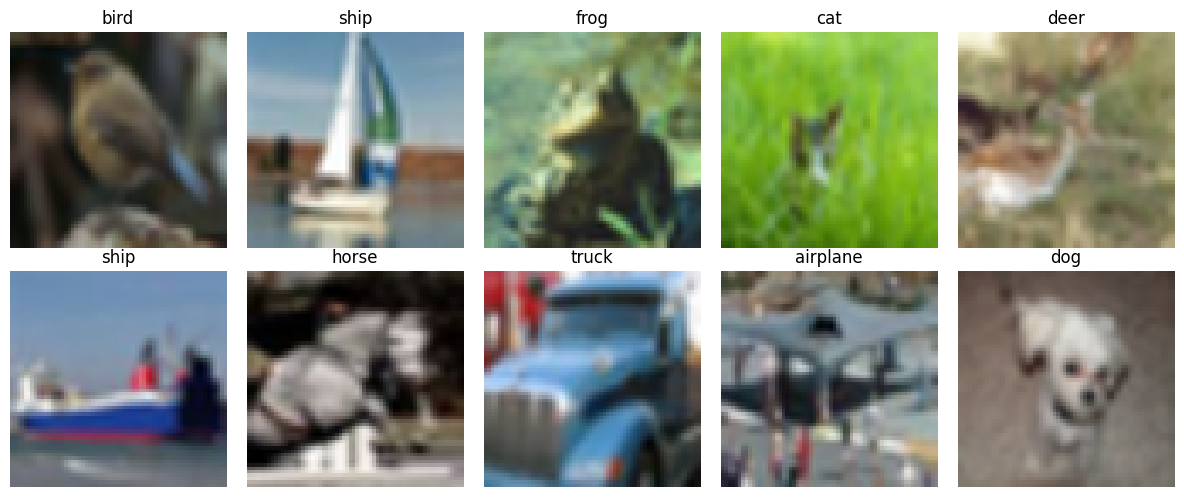

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = (images[i] * 255).astype('uint8')
    ax.imshow(img)
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
for i in range(50):
    img = (images[i] * 255).astype('uint8')
    Image.fromarray(img).save(f'../data/raw/raw_{i}.png')

## Part C: Define Augmentation Pipeline

In [6]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Pad(padding=4),
    transforms.RandomCrop(size=32),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomGrayscale(p=0.1)
])

print("Augmentation pipeline created with the following transformations:")
print("1. Random Horizontal Flip (p=0.5)")
print("2. Random Rotation (degrees=±15)")
print("3. Padding (4 pixels)")
print("4. Random Crop (32×32)")
print("5. Color Jitter (brightness=0.2, contrast=0.2)")
print("6. Random Grayscale (p=0.1)")


Augmentation pipeline created with the following transformations:
1. Random Horizontal Flip (p=0.5)
2. Random Rotation (degrees=±15)
3. Padding (4 pixels)
4. Random Crop (32×32)
5. Color Jitter (brightness=0.2, contrast=0.2)
6. Random Grayscale (p=0.1)


## Part D: Visualize Augmentations

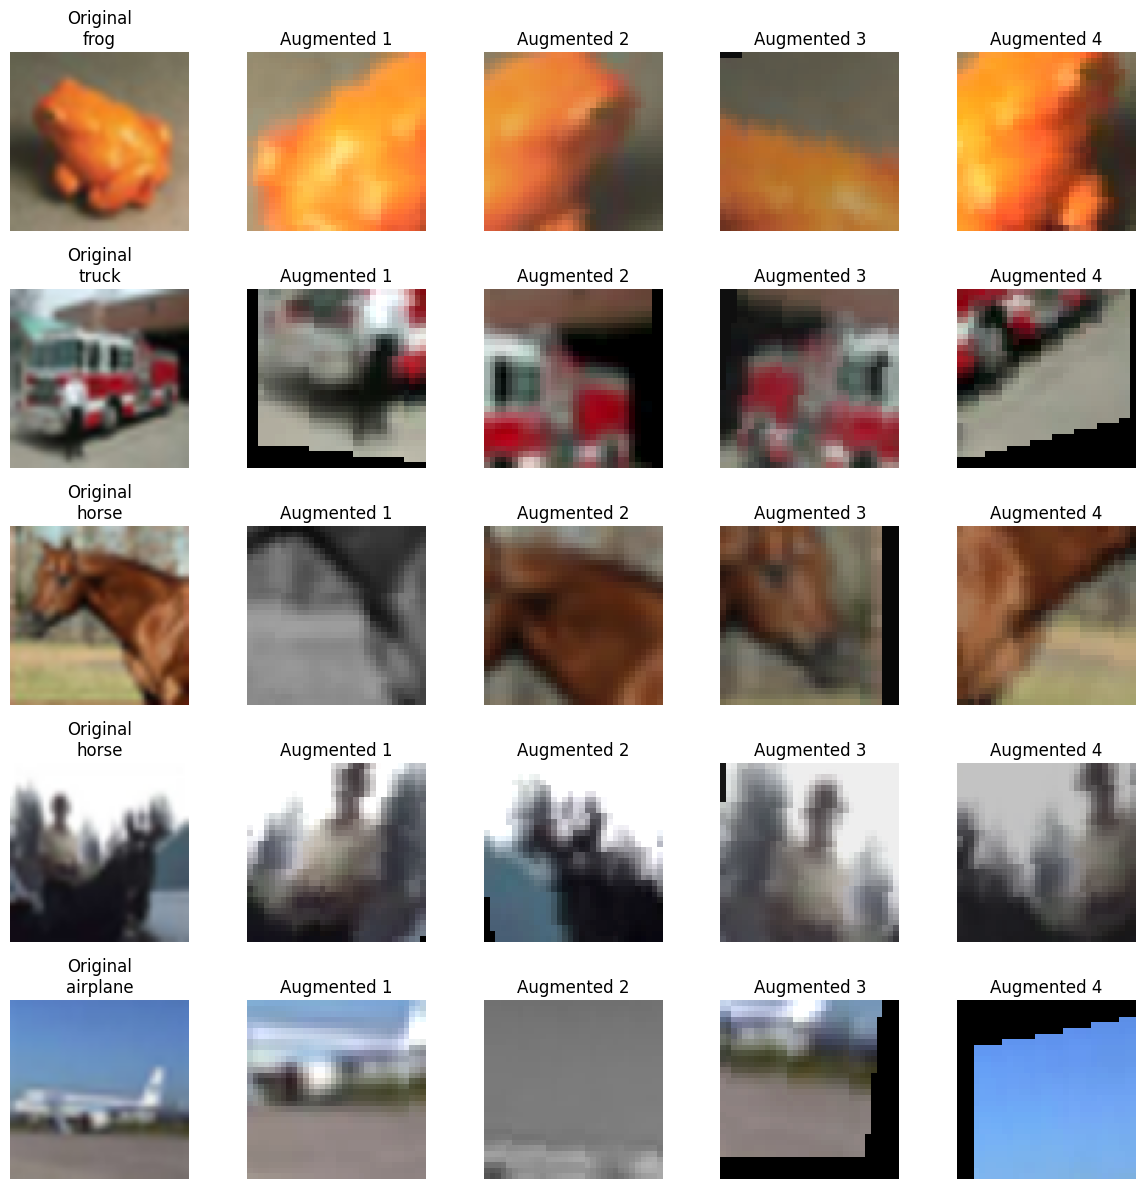

In [7]:
np.random.seed(42)
vis_indices = np.random.choice(len(images), 5, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for row in range(5):
    idx = vis_indices[row]
    img_array = (images[idx] * 255).astype('uint8')
    img = Image.fromarray(img_array)
    label = labels[idx]
    
    axes[row, 0].imshow(img_array)
    axes[row, 0].set_title(f'Original\n{class_names[label]}')
    axes[row, 0].axis('off')
    
    torch.manual_seed(row)
    for col in range(1, 5):
        aug_img = augmentation(img)
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmented {col}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/lab03_augmentation_examples.png')
plt.show()

In [8]:
for i in range(50):
    img_array = (images[i] * 255).astype('uint8')
    img = Image.fromarray(img_array)
    
    aug_flip = transforms.RandomHorizontalFlip(p=1.0)(img)
    aug_flip.save(f'../data/processed/aug_flip_{i}.png')
    
    aug_rotate = transforms.RandomRotation(degrees=15)(img)
    aug_rotate.save(f'../data/processed/aug_rotate_{i}.png')
    
    aug_crop = transforms.Compose([transforms.Pad(4), transforms.RandomCrop(32)])(img)
    aug_crop.save(f'../data/processed/aug_crop_{i}.png')
    
    aug_color = transforms.ColorJitter(brightness=0.3, contrast=0.3)(img)
    aug_color.save(f'../data/processed/aug_color_{i}.png')

## Part E: Augmentation Summary Logging

In [9]:
log_text = """Augmentation Configuration Summary

List of augmentations used:
1. Random Horizontal Flip
2. Random Rotation
3. Random Crop with Padding
4. Color Jitter
5. Random Grayscale

Parameters:
- Rotation angle range: ±15 degrees
- Crop size: 32x32
- Padding: 4 pixels
- Flip probability: 0.5
- Color jitter brightness: 0.2
- Color jitter contrast: 0.2
- Grayscale probability: 0.1
"""

with open('../outputs/logs/lab03_augmentation_config.txt', 'w') as f:
    f.write(log_text)

print("Augmentation configuration saved")

Augmentation configuration saved


## Part F: Dataset Balance Check

In [10]:
counts = pd.Series(labels).value_counts().sort_index()
counts.index = [class_names[i] for i in counts.index]

print("Class Distribution:")
print(counts)

counts.to_csv('../outputs/tables/lab03_class_distribution.csv')
print("\nClass distribution saved")

Class Distribution:
airplane      505
automobile    460
bird          519
cat           486
deer          519
dog           488
frog          519
horse         486
ship          520
truck         498
Name: count, dtype: int64

Class distribution saved


**Why augmentation does not change class distribution:**

Data augmentation applies transformations to existing images during training but does not create new permanent samples in the dataset. The augmentations happen on-the-fly, so the original class distribution counts remain the same. Each original image still has its original label, and augmented versions are just temporary variations of the same image with the same label.

## Results and Discussion

### A. Augmentation Pipeline Design

**Augmentations used:**

1. **Random Horizontal Flip** - Helps the model learn that objects can appear facing left or right, improving generalization to different orientations.

2. **Random Rotation (±15 degrees)** - Teaches the model to recognize objects at slight angles, making it robust to camera tilt or object orientation.

3. **Random Crop with Padding** - Simulates different viewpoints and scales, helping the model focus on object features rather than exact positioning.

4. **Color Jitter** - Makes the model robust to different lighting conditions and camera settings by varying brightness and contrast.

5. **Random Grayscale** - Occasionally converts images to grayscale, forcing the model to learn shape features instead of relying only on color.

### B. Visual Evidence

The saved augmentation figure shows the original images alongside four augmented versions. The variations include rotations, flips, brightness changes, and crops while keeping the object recognizable.

### C. Appropriateness of Augmentation

**Safe augmentations for CIFAR-10:**
1. Horizontal flip - Objects like cars, planes, and ships can face either direction
2. Small rotations - Real-world objects can be tilted slightly

**Potentially unsafe augmentation:**
Vertical flip could be unsafe for some classes. For example, flipping a horse or truck upside down would create unrealistic images that don't represent real-world scenarios.

### D. Expected Effect on Training

Augmentation reduces overfitting by showing the model different variations of each image. This means the model cannot memorize exact pixel patterns. We expect training accuracy to be slightly lower because the task is harder, but validation accuracy should be higher because the model learns more generalizable features instead of memorizing the training set.

## Questions (Answer Individually)

**1. What is data augmentation and why is it commonly used in perception tasks?**

Data augmentation is the process of creating modified versions of training images using transformations that preserve the label, such as rotation, flipping, cropping, and color adjustments. It is commonly used in perception tasks because it artificially expands limited datasets and helps prevent overfitting by teaching the model to recognize objects under different conditions like lighting, angles, and positions. This technique enables models to learn more robust features without needing to collect additional real-world data.

**2. Give three examples of augmentations that are usually label-preserving for object classification.**

Three examples of label-preserving augmentations include horizontal flip where the object remains the same just facing the opposite direction, small rotation where the object is still the same just tilted slightly, and brightness adjustment where the object looks the same under different lighting conditions. These transformations maintain the semantic content and class label of the image while providing visual diversity for training.

**3. What is one example of an augmentation that can break labels for some tasks? Explain.**

Vertical flip can break labels for tasks involving text recognition or digit classification because flipping the number 6 upside down makes it look like a 9, which fundamentally changes its label. Similarly, most real-world objects like cars and animals are never seen upside down in natural settings, making vertical flips unrealistic and potentially harmful to model performance.

**4. Why is on-the-fly augmentation preferred over saving all augmented images in many projects?**

On-the-fly augmentation is preferred because it saves significant storage space by not requiring thousands of augmented images to be stored on disk. Additionally, it provides greater variety since each training epoch can generate different random augmentations of the same image, rather than using the same fixed augmented versions repeatedly, which leads to better model generalization.

**5. If your model overfits heavily, how can augmentation help? Give a practical explanation.**

When a model overfits, it memorizes the exact appearance of training images instead of learning generalizable features, resulting in poor performance on new data. Augmentation addresses this by forcing the model to see different variations of each image in every epoch, preventing it from memorizing specific pixel patterns and instead learning robust object features that remain consistent across all augmented variations.

## Conclusion

In this laboratory exercise, we successfully implemented a comprehensive data augmentation pipeline for the CIFAR-10 dataset using six transformations: random horizontal flip (p=0.5), random rotation (±15 degrees), padding (4 pixels), random crop (32×32), color jitter (brightness and contrast at 0.2), and random grayscale conversion (p=0.1). The visualizations generated in Part D provide clear evidence that these augmentations produce realistic variations of the original images while maintaining object recognizability and preserving their class labels, demonstrating that the transformations mimic real-world changes such as different camera angles, lighting conditions, and positioning. Data augmentation is essential before training CNNs because it artificially expands limited datasets by generating diverse training samples, which prevents the model from overfitting by memorizing specific pixel patterns in the training data. By exposing the network to varied transformations of each image, augmentation forces the CNN to learn robust and generalizable features rather than superficial characteristics, ultimately improving model performance on unseen data. This technique is particularly valuable in perception tasks where collecting additional real-world data can be costly or impractical, as it allows models to encounter variations that simulate different environmental conditions, camera settings, and object orientations. The on-the-fly nature of our augmentation pipeline ensures that each training epoch presents slightly different versions of the same images, maximizing diversity without requiring additional storage space. Our class distribution analysis confirmed that augmentation does not alter the balance of samples per class, as transformations are applied dynamically during training rather than creating permanent new samples in the dataset. Through this lab, we demonstrated that properly designed augmentation strategies are fundamental to training effective CNNs that can generalize well beyond their training data and perform reliably in real-world applications.